In [1]:
pip install pandas



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
dataset = '/Users/brendonngiam/Downloads/dataset0.json.gz'
labels = '/Users/brendonngiam/Downloads/data.info.labelled'


import gzip
import json
import pandas as pd

# Load the RNA-Seq data from the gzipped JSON file
with gzip.open(dataset, 'rt', encoding='utf-8') as f:
    rna_data = [json.loads(line) for line in f]

labels_df = pd.read_csv(labels, header=None, names=['gene_id', 'transcript_id', 'transcript_position', 'label'])

In [3]:
rows = []

# Iterate through each entry in the RNA data
for entry in rna_data:
    for transcript_id, positions in entry.items():
        for position, nucleotides in positions.items():
            for nucleotide, features in nucleotides.items():
                # Iterate through the features and create a row for each set of features
                for feature_set in features:
                    # Append a row with the relevant data
                    row = [transcript_id, position, nucleotide] + feature_set
                    rows.append(row)

# Create a DataFrame from the list of rows
columns = ['transcript_id', 'position', 'nucleotide'] + [f'feature_{i+1}' for i in range(9)]  # Assuming there are 9 features
rna_df = pd.DataFrame(rows, columns=columns)

# Display the first few rows of the DataFrame
rna_df.head()

,transcript_id,position,nucleotide,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
0,ENST00000000233,244,AAGACCA,0.00299,2.06,125.0,0.01770,10.40,122.0,0.00930,10.90,84.1
1,ENST00000000233,244,AAGACCA,0.00631,2.53,125.0,0.00844,4.67,126.0,0.01030,6.30,80.9
2,ENST00000000233,244,AAGACCA,0.00465,3.92,109.0,0.01360,12.00,124.0,0.00498,2.13,79.6
3,ENST00000000233,244,AAGACCA,0.00398,2.06,125.0,0.00830,5.01,130.0,0.00498,3.78,80.4
4,ENST00000000233,244,AAGACCA,0.00664,2.92,120.0,0.00266,3.94,129.0,0.01300,7.15,82.2


In [4]:
aggregated_df = rna_df.groupby(['transcript_id', 'position', 'nucleotide']).mean().reset_index()

# Display the aggregated DataFrame
aggregated_df.head()

,transcript_id,position,nucleotide,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
0,ENST00000000233,244,AAGACCA,0.008264,4.223784,123.702703,0.009373,7.382162,125.913514,0.007345,4.386989,80.570270
1,ENST00000000233,261,CAAACTG,0.006609,3.216424,109.681395,0.006813,3.226535,107.889535,0.007710,3.016599,94.290698
2,ENST00000000233,316,GAAACAG,0.007570,2.940541,105.475676,0.007416,3.642703,98.947027,0.007555,2.087146,89.364324
3,ENST00000000233,332,AGAACAT,0.010620,6.476350,129.355000,0.008632,2.899200,97.836500,0.006101,2.236520,89.154000
4,ENST00000000233,368,AGGACAA,0.010701,6.415051,117.924242,0.011479,5.870303,121.954545,0.010019,4.260253,85.178788


In [5]:
final_df = aggregated_df.merge(labels_df, left_on=['transcript_id', 'position'], right_on=['transcript_id', 'transcript_position'], how='left')
final_df.head()

,transcript_id,position,nucleotide,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,gene_id,transcript_position,label
0,ENST00000000233,244,AAGACCA,0.008264,4.223784,123.702703,0.009373,7.382162,125.913514,0.007345,4.386989,80.570270,ENSG00000004059,244,0
1,ENST00000000233,261,CAAACTG,0.006609,3.216424,109.681395,0.006813,3.226535,107.889535,0.007710,3.016599,94.290698,ENSG00000004059,261,0
2,ENST00000000233,316,GAAACAG,0.007570,2.940541,105.475676,0.007416,3.642703,98.947027,0.007555,2.087146,89.364324,ENSG00000004059,316,0
3,ENST00000000233,332,AGAACAT,0.010620,6.476350,129.355000,0.008632,2.899200,97.836500,0.006101,2.236520,89.154000,ENSG00000004059,332,0
4,ENST00000000233,368,AGGACAA,0.010701,6.415051,117.924242,0.011479,5.870303,121.954545,0.010019,4.260253,85.178788,ENSG00000004059,368,0


In [19]:
# Count positive and negative labels
label_counts = final_df['label'].value_counts()
print(label_counts)


label
0    116363
1      5475
Name: count, dtype: int64


In [20]:
from sklearn.model_selection import train_test_split

unique_genes = final_df['gene_id'].unique()
train_genes, test_genes = train_test_split(unique_genes, test_size=0.3, random_state=42)

train_df = final_df[final_df['gene_id'].isin(train_genes)]
test_df = final_df[final_df['gene_id'].isin(test_genes)]

In [10]:
len(train_df)

84732

In [12]:
train_df.head()

,transcript_id,position,nucleotide,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,gene_id,transcript_position,label
18,ENST00000000412,1190,GTGACTT,0.007106,4.313182,103.048485,0.007846,7.830606,122.181818,0.008827,3.241364,90.765152,ENSG00000003056,1190,0
19,ENST00000000412,1209,TAAACCT,0.008164,1.991226,104.501613,0.006083,3.149129,99.582258,0.006428,2.160387,85.356452,ENSG00000003056,1209,0
20,ENST00000000412,1250,ATGACCA,0.008888,5.232500,87.517857,0.006250,7.535536,118.892857,0.006159,3.139107,79.283929,ENSG00000003056,1250,0
21,ENST00000000412,1283,ATGACCA,0.007014,5.788033,90.090164,0.006673,8.068689,116.704918,0.007498,4.109180,80.998361,ENSG00000003056,1283,0
22,ENST00000000412,1343,CAAACCA,0.007237,2.338769,105.738462,0.006641,3.973538,95.776923,0.006715,1.910215,81.786154,ENSG00000003056,1343,0


In [21]:
# Features and labels for training
X_train = train_df[['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']]
y_train = train_df['label']

# Features and labels for testing
X_test = test_df[['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']]
y_test = test_df['label']

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform the training data
X_test_scaled = scaler.transform(X_test)  # Transform the test data

# Creating the model with increased max_iter and a different solver
model = LogisticRegression(solver='liblinear', max_iter=2000)

# Fitting the model
model.fit(X_train_scaled, y_train)

# Making predictions
y_pred = model.predict(X_test_scaled)

# Evaluating the model
print(classification_report(y_test, y_pred))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98     35491
           1       0.00      0.00      0.00      1615

    accuracy                           0.96     37106
   macro avg       0.48      0.50      0.49     37106
weighted avg       0.91      0.96      0.94     37106



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 8.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 9.0 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.2/249.2 kB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


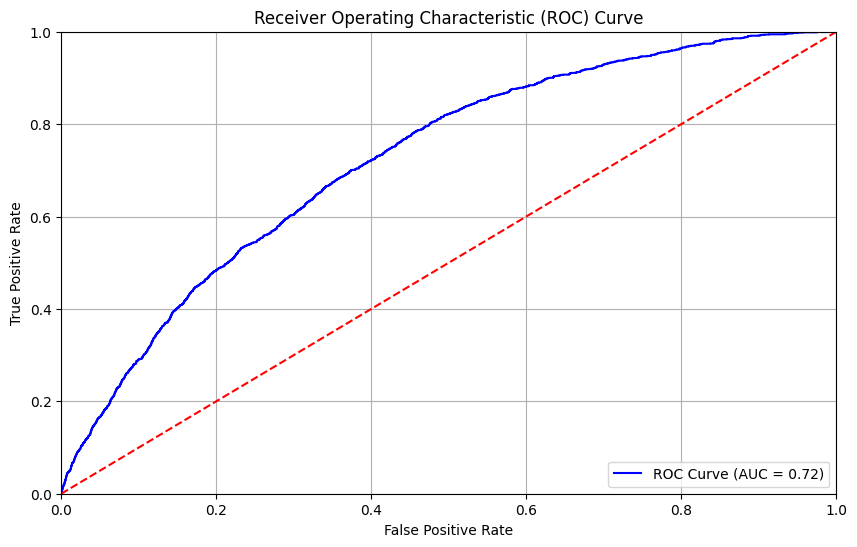

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

# Ensure y_train and y_test are in the correct format
y_train = y_train.astype(int)  # Convert to integers
y_test = y_test.astype(int)      # Convert to integers

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform the training data
X_test_scaled = scaler.transform(X_test)  # Transform the test data

# Creating the model with increased max_iter and a different solver
model = LogisticRegression(penalty='l2',solver='liblinear', max_iter=2000)

# Fitting the model
model.fit(X_train_scaled, y_train)

# Making predictions (get probabilities)
y_scores = model.predict_proba(X_test_scaled)[:, 1]  # Probability of the positive class

# Computing the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculating the AUC
auc_score = roc_auc_score(y_test, y_scores)

# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (no discrimination)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()